In [150]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [151]:
import matplotlib
matplotlib.__version__

'2.2.3'

## Engineering

In [152]:
df = pd.read_csv('data/covid_19_data.csv')
qc = df[df['Province/State'] == 'Quebec'].copy().reset_index()
qc['ObservationDate'] = pd.to_datetime(qc['ObservationDate'])
qc['DateUnix'] = qc['ObservationDate'].apply(lambda date: date.toordinal())
qc['DateUnix'] = qc['DateUnix'].astype(float)
qc['DateUnix2'] = (qc['DateUnix'] ** 2).astype(float)
qc['DateUnix3'] = (qc['DateUnix'] ** 3).astype(float)
qc['ObsDateMs'] = pd.to_datetime(qc['ObservationDate'], unit='ms')

"""
Calculating daily change
"""
qc.loc[0, 'DailyDeaths'] = qc.loc[0, 'Deaths']
qc.loc[0, 'DailyConfirmed'] = qc.loc[0, 'Confirmed']
for i in range(1, len(qc)):
    changeD = qc.loc[i, 'Deaths'] - qc.loc[i-1, 'Deaths'] 
    changeC = qc.loc[i, 'Confirmed'] - qc.loc[i-1, 'Confirmed'] 
    qc.loc[i, 'DailyDeaths'] = changeD if changeD >= 0 else 0
    qc.loc[i, 'DailyConfirmed'] = changeC if changeC >= 0 else 0

"""
We have random daily spikes of ~8000 cases for a given day, 
We'll isolate those based on Bing's chart, which shows a max count of
daily cases of approx 4000.
https://www.bing.com/covid/local/quebec_canada
"""
qc = qc[qc['DailyConfirmed'] <= 4000]

"""
To make up for internal factors of the reporting system
of cases, we'll remove 0 DailyConfirmed rows.
"""
qc = qc[qc['DailyConfirmed'] > 0]

imp_dates = ['20/3/2020', '31/8/2020','25/12/2020']
# qc

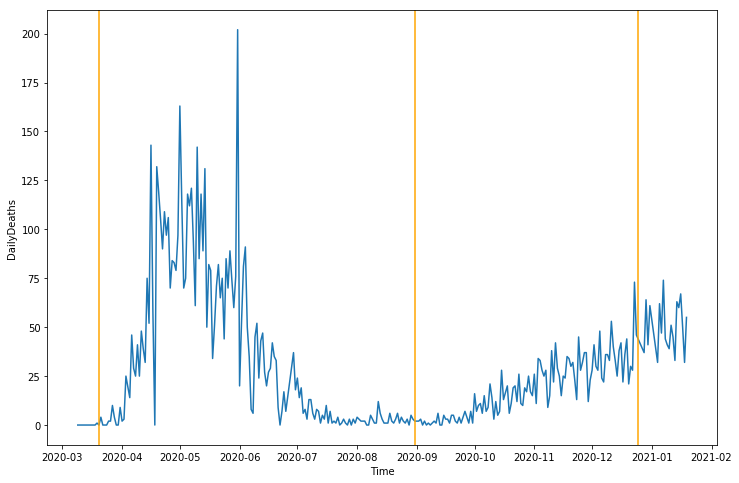

In [242]:
plt.figure(figsize=(12.,8.))
plt.plot(np.asarray(qc['ObservationDate'])[:np.newaxis],np.asarray(qc['DailyDeaths'])[:np.newaxis])
for d in imp_dates:
    plt.axvline(x=pd.to_datetime(d), color='orange')
plt.ylabel("DailyDeaths")
plt.xlabel("Time")
plt.show()

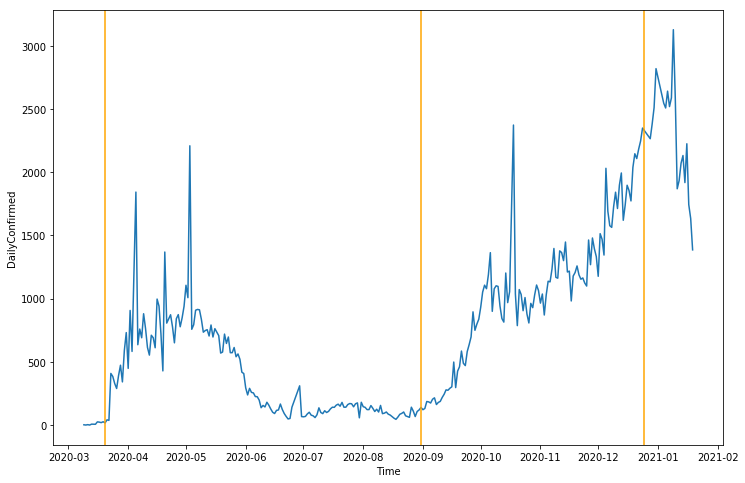

In [243]:
plt.figure(figsize=(12.,8.))
plt.plot(np.asarray(qc['ObservationDate'])[:np.newaxis],np.asarray(qc['DailyConfirmed'])[:np.newaxis])
for d in imp_dates:
    plt.axvline(x=pd.to_datetime(d), color='orange')
plt.ylabel("DailyConfirmed")
plt.xlabel("Time")
plt.show()

## Split and fit

We can see here that Confirmed cases seem to have a much more interesting variation in trends.

Here we split out delimiters into tranches

In [244]:
delimiters = [
    '1/1/2020',
    '3/20/2020',
    '5/1/2020',
    '6/1/2020',
    '8/31/2020',
    '11/1/2020',
    '12/25/2020',
    '1/20/2021'
]
tranches = [[delimiters[i-1], delimiters[i]] for i in range(1,len(delimiters))]

sets = [
    qc[
        (pd.to_datetime(tranches[i][0]) < qc['ObservationDate']) & (qc['ObservationDate'] <= pd.to_datetime(tranches[i][1]))
    ] for i in range(len(tranches))
]
tranches

[['1/1/2020', '3/20/2020'],
 ['3/20/2020', '5/1/2020'],
 ['5/1/2020', '6/1/2020'],
 ['6/1/2020', '8/31/2020'],
 ['8/31/2020', '11/1/2020'],
 ['11/1/2020', '12/25/2020'],
 ['12/25/2020', '1/20/2021']]

In [245]:
from sklearn.metrics import r2_score
from scipy.stats import linregress

def rows_between(df, dates):
    return df[
            (pd.to_datetime(dates[0]) < df['ObservationDate']) & (df['ObservationDate'] <= pd.to_datetime(dates[1]))
        ]

def evaluate_tranches(data,
                      tranches=[],
                      imp_dates=[],
                      filters=[None, 1000, 1000, 300, 1250, None, 2650,None],
                      colors=['orange', 'red', 'purple', 'teal', 'brown', 'yellow', 'green'],
                      date_filters = [None, None, None, None, None, None, None],
                      degrees=[2, 3, 3, 3, 2, 2, 2],
                      figsize=(15.,15.)):
    
    sets = [rows_between(data, tranches[i]) for i in range(len(tranches))]
    
    if len(tranches) > 0:
        plt.figure(figsize=figsize)

    for i in range(len(sets)):
        if filters[i] != None:
            sets[i] = sets[i][sets[i]['DailyConfirmed'] <= filters[i]]
        if date_filters[i] != None:
            sets[i] = sets[i][sets[i]['ObservationDate'] <= pd.to_datetime(date_filters[i])]

    scores = []
    start = []
    end = []
    coef1 = []
    coef2 = []
    ones = []
    twos = []
    slopes = []

    for i in range(len(sets)):
        x = sets[i]['ObservationDate'][:, np.newaxis]
        y = sets[i]['DailyConfirmed']
        X = sm.add_constant(sets[i]['DateUnix'])
        deg = degrees[i]
        poly = PolynomialFeatures(degree = deg) 
        X_poly = poly.fit_transform(X)
        pr_model = LinearRegression().fit(X_poly, y)
        y_hat = pr_model.predict(X_poly)
        linr = linregress(np.asarray(sets[i]['DateUnix'])[:np.newaxis], y_hat)
        plt.scatter(np.asarray(x)[:np.newaxis],np.asarray(y)[:np.newaxis], color=colors[i], label=" to ".join(tranches[i]))
        plt.plot(np.asarray(x)[:np.newaxis],np.asarray(y_hat)[:np.newaxis], color='blue')

        """
        Re-calculating to access the convenience properties of 
        statsmodel.api. 
        Couldn't get the fit lines to curve even with high degrees
        with scikitlearn for some reason
        """
        est = sm.OLS(y,sm.add_constant(sets[i][['DateUnix','DateUnix2']])).fit()
        summary = est.summary2().tables[1]
        r_squ = r2_score(y, y_hat)
        pvalues = summary['P>|t|']
        coeffs = summary['Coef.']
        
        scores.append(r_squ)
        start.append(tranches[i][0])
        end.append(tranches[i][1])
        coef1.append(coeffs['DateUnix'])
        coef2.append(coeffs['DateUnix2'])
        ones.append(pvalues['DateUnix'])
        twos.append(pvalues['DateUnix2'])
        slopes.append(linr.slope)

    if len(imp_dates) > 0:
        for d in imp_dates:
            plt.axvline(x=pd.to_datetime(np.asarray(d)), color='orange')

    res = pd.DataFrame({
        'tranche': tranches,
        'start': start,
        'end': end,
        'r2': scores,
        'coeff1': coef1,
        'coeff2': coef2,
        'p_deg1': ones,
        'p_deg2': twos,
        'color': colors[:len(tranches)],
        'slope': slopes
    })
    res['end_date'] = pd.to_datetime(res['end'])
    if len(tranches) > 0:
        plt.xlabel('Date')
        plt.ylabel('Confirmed Cases')
        plt.legend()
    return res


## RDD Plot

/home/jlmy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/jlmy/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
/home/jlmy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/jlmy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/jlmy/anaconda3/lib/python3.7/site-packages/ip

,tranche,start,end,r2,coeff1,coeff2,p_deg1,p_deg2,color,slope,end_date
0,"[1/1/2020, 3/20/2020]",1/1/2020,3/20/2020,0.734381,-2.362386,0.000003,7.858330e-04,7.857943e-04,orange,2.362420,2020-03-20
1,"[3/20/2020, 5/1/2020]",3/20/2020,5/1/2020,0.670168,-14.760975,0.000020,3.866968e-08,3.862219e-08,red,14.762784,2020-05-01
2,"[5/1/2020, 6/1/2020]",5/1/2020,6/1/2020,0.837183,15.881168,-0.000022,7.333648e-11,7.342788e-11,purple,-15.879310,2020-06-01
3,"[6/1/2020, 8/31/2020]",6/1/2020,8/31/2020,0.227581,0.799112,-0.000001,5.070719e-05,5.087606e-05,teal,-0.798786,2020-08-31
4,"[8/31/2020, 11/1/2020]",8/31/2020,11/1/2020,0.866504,-17.016356,0.000023,2.045344e-19,2.040436e-19,brown,17.018399,2020-11-01
5,"[11/1/2020, 12/25/2020]",11/1/2020,12/25/2020,0.842046,-21.081316,0.000029,1.083890e-17,1.079824e-17,yellow,21.085228,2020-12-25
6,"[12/25/2020, 1/20/2021]",12/25/2020,1/20/2021,0.781984,39.225364,-0.000053,8.619181e-04,8.624779e-04,green,-39.219031,2021-01-20


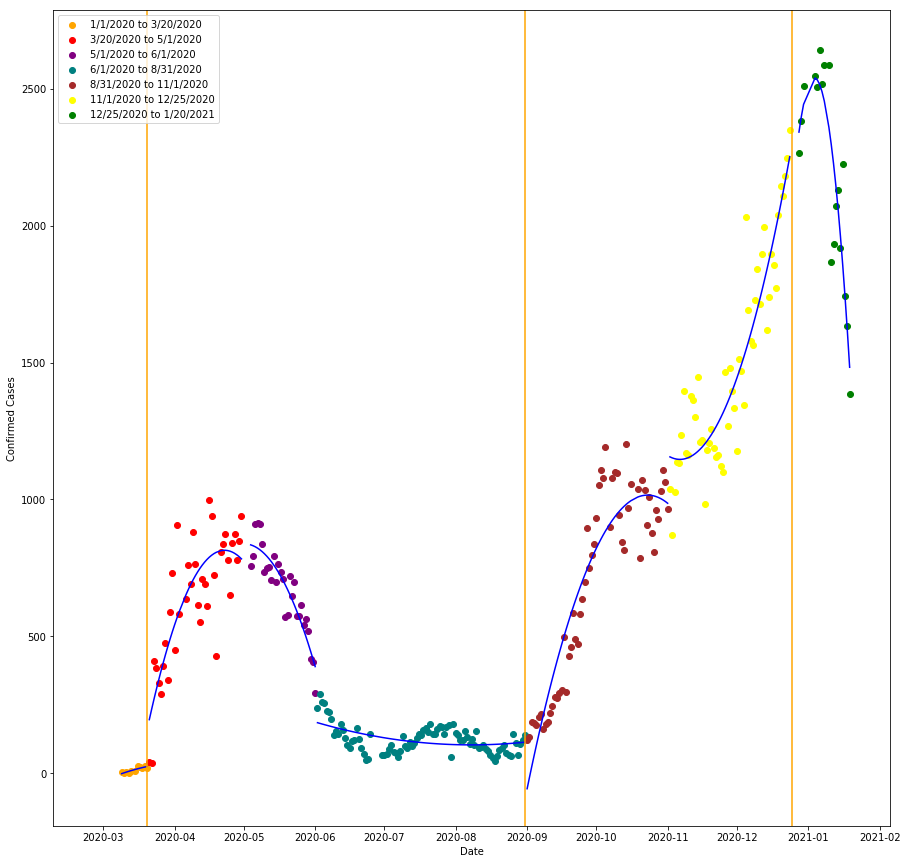

In [246]:
res = evaluate_tranches(data=qc,tranches=tranches,imp_dates=imp_dates)

res

## P-Value

We can notice that our p-values for both 2nd degree and 3rd degree polynomial fits are near-zero, which indicates we do not need to fit to a polynomial higher than 2.


## Justification

1. First, we went with evaluating each cutoff and we noticed that we would get better fits by adding some more cutoffs around what appeared to be the peaks of the scatterplot. From this, we determined that an ideal fit around each cutoff was approx 30 days. This makes sense, since if we consider that the incubation of COVID is 14 days, and that a COVID test result takes at least 48hrs, then it makes sens that one would not see any meaningful fit with +/- periods of less than at least 14-16 days around the cutoffs.
2. Based on the fit we noticed above, we went with a 2nd degree polynomial fit, since most of our coefficients and p-values for the 3rd degree factor were near 0, or 0, meaning there was likely some overfit for a higher than 2nd degree.
3. We extracted outliners, that were usually on or above the 85th percentile of values for a given tranche (we define a tranche as the period between two cutoff dates). We also stretched out the dataset to beyond 31-12-2020 to after the Quebec curfew, to further accentuate the drop in cases after the Christmas day lockdown.
4. To get the slope on each side of a cutoff, we could have used calculus to calculate the derivative of the 2nd degree polynomial of the fit function on either side ofthe cutoff date, then compute the slope with x = (cutoff date) +/- 1 day. However, we used the linregression scikitlearn method to extract this so as to maintain some simplicity in our algorithmic approach. We kept this method since the values found for the slopes do maintain the positivity or negativity that is suggested visually on the plot. 

In [247]:
slopes = pd.DataFrame({ 
    'imp_date': ['3/20/2020', '8/31/2020', '12/25/2020'],
})
slopes['slope_delta'] = slopes['imp_date'].apply(
    lambda date: res[res['start'] == date].iloc[0]['slope'] - res[res['end'] == date].iloc[0]['slope']
)
slopes['imp_date'] = pd.to_datetime(slopes['imp_date'])
slopes

,imp_date,slope_delta
0,2020-03-20,12.400364
1,2020-08-31,17.817185
2,2020-12-25,-60.304259


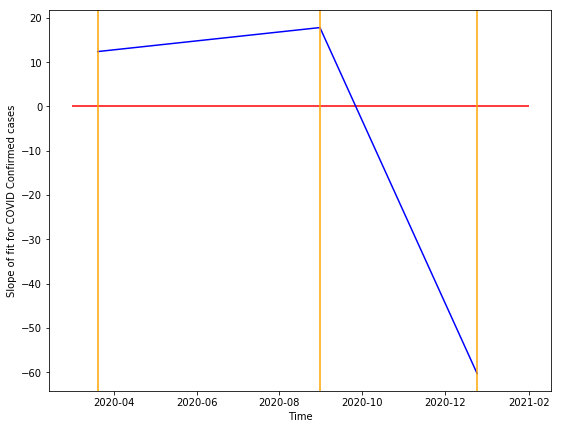

In [248]:
resc = res.copy()
plt.figure(figsize=(9.,7.))
plt.plot(np.asarray(slopes['imp_date'])[:, np.newaxis],np.asarray(slopes['slope_delta'])[:, np.newaxis], color='blue')
plt.hlines([0],pd.to_datetime('3/01/2020'),pd.to_datetime('2/01/2021'), color='red')
plt.ylabel("Slope of fit for COVID Confirmed cases")
plt.xlabel("Time")
for d in imp_dates:
    plt.axvline(x=pd.to_datetime(d), color='orange')

## Findings

First, we noticed that the difference in growth in confirmed cases is:
1. positive for 
    a. 3/20, at 12 more cases per day than the previous day; and
    b. 8/30, at 17 more cases per day than the previous day;
2. negative for 12/25 at 60 less cases per day on average than the previous day.

This implies that neither of the 20/3 lockdown and the reopenning of schools on 31/8  had an immediate effect on the number of confirmed COVID cases. This is to be expected however, given that the point we made earlier outlining that it can take up to 14-16 days for a patient to be confirmed as COVID+. This means, that while these two dates had no immediate effect, the were not necessarilly ineffective, they were probably done too late considering the time delay in confirming cases.
There is also  the possibility that testing methods we not as efficient or available on 20/3 compared to 8/31. Meaning, results earlier in the year are more likely to be falsy, biases or not fully representative of the actual landscape of cases.
However, we can see that the lockdown on 20/3 did "flatten" the curve by mid-may. Re-oppening schools however, had no significant effect since cases grew much quicker afterwards. In fact, the growth in number of cases grew in the second tranche from 17.018399 during 8/31/2020 to 11/1/2020, to 21.085228 during 11/1/2020 to 12/25/2020.

Again, difference in growth might be correlated to the difference in the soffistication of testing processes between Q4 2020 and Q2 2020.

Regarding the Christmas lockdown however, we can notice a very sharp decline in cases. Which is also coupled with a reported spike in travels. This is remarkable, since the province also recommended that persons avoid large gatherings, and also introduced a curfew just 10 days after the lockdown.
While the amount of data after the third lockdown is still very limited compared to the rest of 2020, should the trend continue this way, we can assume that a strict, and curfewed lockdown is a much better idea than partial lockdowns or experimental re-opennings.